## Run initialization in analysis.py

In [2]:
# -*- coding: utf-8 -*-
"""
"""
import matplotlib
matplotlib.use('Agg')

from analysis_and_visualization import perform_analysis_and_visualization
from mozaik.storage.datastore import Hdf5DataStore, PickledDataStore
from mozaik.controller import Global
from parameters import ParameterSet
import mozaik
from mozaik.controller import setup_logging
import sys 

root = 'results/run2'
Global.root_directory = root+'/'

setup_logging()
data_store = PickledDataStore(load=True, parameters=ParameterSet(
    {'root_directory': root, 'store_stimuli': False}), replace=True)

## Analysis and visualization full file

In [68]:
import os
import psutil
import sys
import mozaik
from mozaik.visualization.plotting import *
from mozaik.analysis.technical import NeuronAnnotationsToPerNeuronValues
from mozaik.analysis.analysis import *
from mozaik.analysis.vision import *
from mozaik.storage.queries import *
from mozaik.storage.datastore import PickledDataStore
from mozaik.controller import Global
from visualization_functions import *

import ast
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import signal
from scipy import stats
from scipy import optimize
from scipy.ndimage import center_of_mass
from mozaik.tools.distribution_parametrization import load_parameters

class ExportStimulusResponseData(Analysis):
      """
      This analysis exports paired stimulus vs response data. Its intended use is to generate input to
      ML models for identification of stimulus-response function. 

      If signal_type= Vm or cond_Eor cond_I, corresponding recorded signal will be exported.
      If signal_type=ASL, the analysis assumes a datastore filled with AnalogSignalList data structures of identical parametrization with the exception of stimulus.

      Stimulus-response pairs will be concatenated across all different segments or AnalogSignalList data structures in the data store view. 

      For each semgent or AnalogSignalList of signal length X ms, X/period data pairs (A,B) will be exported, where
      A is 2D matrix corresponding to the pixels of the stimulus presented during the given period in the visual field 
      (the stimulus is assumed to be constant during the period). B is the response signal averaged over the given period.

      Following structure will be dumped using the cpickle.dump method into the export file:
      {
        "stim" : ndarray,  #contains 3D ndarray of size (X,Y,T), where X,Y are the visual field dimensions, and T corresponds to the number of periods across all the segments or AnalogSignalLists in the provided data store view. 
        "resp" : ndarray,  #contains 2D ndarray of size (T,N), where T was explained above and N us the number of neurons.      
      }



      Other parameters
      ------------------- 
      period : float (ms)
                     The period over which to average the response signal. The stimulus has to be constant over this period of time.

      neurons : list(int)
                     List of neuron ids for which to export the response

      signal_type : str
                     Currently understood are [Vm,cond_E,cond_I, ASL]. The first three are the corresponding recorded signals. ASL is any AnalogSignalList deposited in the analysis data store. 

      file_name : str
                     The name of the file into which data will be stored. The file will be created in the directory containing the datastore. 
      """    
      required_parameters = ParameterSet({
          'period': float,  
          'neurons' : list,
          'signal_type' : str,
          'file_name' : str
      })      

      def perform_analysis(self):
            if self.parameters.signal_type == 'ASL':
                assert queries.equal_ads(self.datastore,except_params=['stimulus_id'])
                assert queries.ads_with_equal_stimulus_type(self.datastore)
                # make sure that the length of all stimuli is multiple of frame length
                assert all([(MozaikParametrized.idd(s).duration % MozaikParametrized.idd(asl.stimulus_id).frame_duration) == 0 for asl in self.datastore.get_analysis_result()])
                frame_duration = MozaikParametrized.idd(self.datastore.get_analysis_result()[0].stimulus_id).frame_duration
            else:
                assert queries.equal_stimulus_type(self.datastore)
                # make sure that the length of all stimuli is multiple of frame length
                assert all([(MozaikParametrized.idd(s).duration % MozaikParametrized.idd(s).frame_duration) == 0 for s in self.datastore.get_stimuli()])
                frame_duration = MozaikParametrized.idd(self.datastore.get_stimuli()[0]).frame_duration

            if self.parameters.signal_type == 'ASL':
                signals,stims = zip(*[(asl.get_asl_by_id(self.parameters.neurons),self.datastore.get_sensory_stimulus([asl.stimulus_id])[0]) for asl in queries.param_filter_query(self.datastore,identifier='AnalogSignalList').get_analysis_result()])
            elif self.parameters.signal_type == 'Vm':
                signals,stims = zip(*[([seg.get_vm(n) for n in self.parameters.neurons],self.datastore.get_sensory_stimulus([st])[0]) for seg,st in zip(self.datastore.get_segments(),self.datastore.get_stimuli())])
            elif self.parameters.signal_type == 'cond_E':
                signals,stims = zip(*[([seg.get_esyn(n) for n in self.parameters.neurons],self.datastore.get_sensory_stimulus([st])[0]) for seg,st in zip(self.datastore.get_segments(),self.datastore.get_stimuli())])                
            elif self.parameters.signal_type == 'cond_I':
                signals,stims = zip(*[([seg.get_isyn(n) for n in self.parameters.neurons],self.datastore.get_sensory_stimulus([st])[0]) for seg,st in zip(self.datastore.get_segments(),self.datastore.get_stimuli())])

            signals = numpy.array([[numpy.reshape(s.magnitude[1:],(int((s.duration.rescale(qt.ms).magnitude-1)/self.parameters.period),-1)) for s in sig] for sig in signals])            
            # push neurons into first axes           
            signals = numpy.swapaxes(signals,0,1)  
            # concatenate over the different recordings or ASLs if there are multiple
            signals = [numpy.concatenate(s,axis=0)  for s in signals]  
            # push neurons last           
            signals = numpy.swapaxes(signals,0,1)
            signals = numpy.swapaxes(signals,1,2)  
            raw_signals = signals.copy()
            logger.info(numpy.shape(raw_signals))

            # average over the signal period
            signals = numpy.mean(signals[:,35:,:],axis=1)
            logger.info(numpy.shape(signals))

            # concatenate over the different recordings or ASLs
            stims = numpy.concatenate(stims)  
            logger.info(numpy.shape(stims))

            #cut up for the indiviudal stimulus presentations of length period
            sh = numpy.shape(stims)
            stims = numpy.reshape(stims,(-1,int(self.parameters.period/frame_duration),sh[1],sh[2]))
            logger.info(numpy.shape(stims))

            # check if the inputs are the same within each period 
            #for i in xrange(0,int(self.parameters.period/frame_duration)):
            #    assert numpy.all(stims[:,0,:,:]==stims[:,i,:,:])
            # remove the same stimuli by averaging over them
            stims = numpy.mean(stims[:,:2,:],axis=1)
            logger.info(numpy.shape(stims))
            return signals,raw_signals,stims

def crop_and_resize_stim(stim, visual_field_size, visual_field_spatial_resolution, stim_size, grid_size):
    ymin = int(np.ceil((visual_field_size[0]-stim_size)/(2*visual_field_spatial_resolution)))
    ymax = ymin + int(stim_size/visual_field_spatial_resolution)
    xmin = int(np.ceil((visual_field_size[1]-stim_size)/(2*visual_field_spatial_resolution)))
    xmax = xmin + int(stim_size/visual_field_spatial_resolution)

    step = int(np.round(stim_size/(grid_size*visual_field_spatial_resolution)))
    cropped_stim = stim[:,ymin:ymax,xmin:xmax]
    cropped_stim = cropped_stim[:,::step,::step]
    return cropped_stim

def RF_distribution(n_samples,pos,neg,signal_averaged,latency,period):
    stim_d0, stim_d1 = pos.shape
    distr = np.zeros((n_samples,stim_d0,stim_d1))
    for d0 in xrange(stim_d0): # stim_d0
        for d1 in xrange(stim_d1): #stim_d1
            p = int(pos[d0,d1])
            n = int(-neg[d0,d1])
            a = p+n
            s = signal_averaged[latency[d0,d1]:-1:period]
            remaining_samples = n_samples * a
            ss = []
            while remaining_samples > 0:
                s_sh = s.copy()
                np.random.shuffle(s_sh)
                s_sh = s_sh[0:len(s)/a]
                ss.append(s_sh)           
                remaining_samples -= len(s)/a
            ss = np.array(ss).flatten()[0:n_samples*a]
            ss = ss.reshape(-1,a)
            mpos = ss[:,:p].mean(axis=1)
            mneg = ss[:,p:].mean(axis=1)
            distr[:,d0,d1] = mpos - mneg
    return distr

def calculate_RFs(stims,raw_signals,background_luminance,max_delay):
    rescaled_stims = (stims-background_luminance)/background_luminance
    pos = rescaled_stims[0]*0
    neg = rescaled_stims[0]*0
    for i in xrange(rescaled_stims.shape[0]):
        pos += numpy.clip(rescaled_stims[i],a_min=0,a_max=None)
        neg += numpy.clip(rescaled_stims[i],a_max=0,a_min=None)
    
    n_stims, period, n_neurons= raw_signals.shape
    _, stim_d0, stim_d1 = rescaled_stims.shape
    print("Number of stimuli: %d, period: %d ms, number of neurons: %d" % (n_stims,period,n_neurons))
    
    RFs = []
    distrs=[]
    latencies=[]
    for n_id in range(n_neurons):
        # Select signal for given neuron
        signal = raw_signals[:,:,n_id]
        signal = signal.flatten()
        # Averaging window with length period, 
        signal_averaged = np.convolve(signal,np.ones(period)/period,'valid')
        
        all_RF_pos = np.zeros((max_delay,rescaled_stims[0].shape[0],rescaled_stims[0].shape[1]))
        all_RF_neg = np.zeros((max_delay,rescaled_stims[0].shape[0],rescaled_stims[0].shape[1]))
        # Find locations of positive stimuli
        A,B,C = np.where(rescaled_stims[0:-1,:,:] > 0)
        # Create histograms of response to positive stimuli for each 
        for i in range(len(A)):
            if A[i]*period+max_delay > len(signal_averaged):
                continue
            all_RF_pos[:,B[i],C[i]] += signal_averaged[A[i]*period:A[i]*period+max_delay]
        A,B,C = np.where(rescaled_stims[0:-1,:,:] < 0)
        for i in range(len(A)):
            if A[i]*period+max_delay > len(signal_averaged):
                continue
            all_RF_neg[:,B[i],C[i]] += signal_averaged[A[i]*period:A[i]*period+max_delay]
        all_RF = (all_RF_pos / pos) - (all_RF_neg / -neg) 
        all_RF = np.nan_to_num(all_RF)

        best_RF = np.zeros(rescaled_stims[0].shape)
        for d0 in xrange(stim_d0):
            for d1 in xrange(stim_d1):
                best_RF[d0,d1] = max(all_RF[:,d0,d1],key=abs)
        latency = np.argmax(abs(all_RF),axis=0)

        distr = RF_distribution(100,pos,neg,signal_averaged,latency,period)
        distrs.append(distr)      
        RFs.append(best_RF)
    return RFs, distrs, latencies        

def confidence_mask(RF,distr,p):
    RF_d0, RF_d1 = RF.shape
    lthresh = np.zeros((RF_d0, RF_d1))
    hthresh = np.zeros((RF_d0, RF_d1))
    for d0 in range(RF_d0):
        for d1 in range(RF_d1):
            hthresh[d0,d1], lthresh[d0,d1] = np.percentile(distr[:,d0,d1],[(1-p/2)*100,p/2*100])
    mask = np.logical_or(RF < lthresh, RF > hthresh)
    return mask

def get_diameter(RF, x_center, y_center):
    y,x = np.where(np.abs(RF)>0)
    diameter = np.sqrt((x-x_center)**2 + (y-y_center)**2)
    return max(diameter)

def gaussian(height, center_y, center_x, sigma):
    """Returns a gaussian function with the given parameters"""
    sigma = float(sigma)
    return lambda y,x: height*np.exp(
                -(((center_x-x)/sigma)**2+((center_y-y)/sigma)**2)/2)

def fitgaussian(data):
    """Returns (height, y, x, sigma)
    the gaussian parameters of a 2D distribution found by a fit"""
    y0,x0 = center_of_mass(data)
    params = [1,y0,x0,1]
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def get_size_and_coords(RF):   
    mode = "GAUSS_FIT"
    
    if mode is "MAX":
        # Get absolute maximum index
        id_1d = np.abs(RF).argmax()
        y,x = np.unravel_index(id_1d, RFs[0].shape)
        #print(y,x)
        diameter = get_diameter(RF, x, y)       

    elif mode is "GAUSS_FIT":
        height,y,x,sigma = fitgaussian(np.abs(RF))
        #print(height,x,y,sigma)
        diameter = 4*sigma
    return diameter,x,y

def transform_to_real_coords(RF,diameter,x,y):
    stim_size = 3.6
    grid_size = 12
    xlen, ylen = RF.shape    
    x_real = (x-xlen/2 - np.sign(x-xlen/2) * 0.5) * (stim_size/grid_size)
    y_real = -(y-ylen/2 - np.sign(y-ylen/2) * 0.5) * (stim_size/grid_size)
    diameter_real = diameter * (stim_size/grid_size)
    return diameter_real, x_real, y_real

def remove_extreme_neurons(neuron_params,xlim,ylim,dlim):
    out = {}
    for n_id, params in neuron_params.items():
        if \
        params["x"] >= xlim[0] and params["x"] <= xlim[1] and \
        params["y"] >= ylim[0] and params["y"] <= ylim[1] and \
        params["diameter"] >= dlim[0] and params["diameter"] <= dlim[1]:
            out[n_id] = params.copy()
    return out

def save_RF_params_to_datastore(datastore, neuron_params, sheet):
    ids = []
    RFs = []
    RFs_masked = []
    x = []
    y = []
    diameter = []
    for n_id in neuron_params: 
        ids.append(n_id)
        RFs.append(neuron_params[n_id]["RF"])
        RFs_masked.append(neuron_params[n_id]["RF_masked"])
        x.append(neuron_params[n_id]["x"])
        y.append(neuron_params[n_id]["y"])
        diameter.append(neuron_params[n_id]["diameter"])   
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(RFs, ids, None,
                        value_name='Receptive Field',
                        sheet_name=sheet,
                        period=None))
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(RFs_masked, ids, None,
                        value_name='Masked Receptive Field',
                        sheet_name=sheet,
                        period=None))
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(x, ids, None,
                        value_name='Receptive Field x',
                        sheet_name=sheet,
                        period=None)) 
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(y, ids, None,
                        value_name='Receptive Field y',
                        sheet_name=sheet,
                        period=None)) 
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(diameter, ids, None,
                        value_name='Receptive Field diameter',
                        sheet_name=sheet,
                        period=None))

def get_sparse_noise_params(data_store):
    return load_parameters(param_filter_query(data_store,st_name='SparseNoise').get_stimuli()[0],{})
    
def sparse_noise_response_data(data_store,sheet):   
    analog_ids = list( 
        param_filter_query(data_store, sheet_name=sheet)
        .get_segments()[0]
        .get_stored_esyn_ids()
    )
    srd_params = { 
          'period': get_sparse_noise_params(data_store)["time_per_image"],  
          'neurons' : analog_ids,
          'signal_type' : "Vm",
          'file_name' : ""
    }
    dsv = param_filter_query(data_store,st_name='SparseNoise',sheet_name=sheet,st_direct_stimulation_name=None)
    _,raw_signals,stims = ExportStimulusResponseData(dsv,ParameterSet(srd_params)).perform_analysis()
    return raw_signals, stims, analog_ids

def load_RF_params_from_datastore(data_store,sheet):
    param_names = ['Receptive Field','Masked Receptive Field','Receptive Field x','Receptive Field y','Receptive Field diameter']
    
    ids = list( 
        param_filter_query(data_store, sheet_name=sheet)
        .get_segments()[0]
        .get_stored_esyn_ids()
    )   
    results = data_store.get_analysis_result(
        identifier="PerNeuronValue",
        value_name=param_names,
        sheet_name=sheet,
    )
    
    rf_params = {}
    for n_id in ids:
        try:
            v = [None] * len(results)
            param_vals = {}
            for i in range(len(results)):
                param_vals[param_names[i]] = results[i].get_value_by_id(n_id)  
            rf_params[n_id]=param_vals
        except ValueError: # Skip neuron ids with no saved RFs
            continue
            
    return rf_params


def find_RF_params(data_store,sheets):
    measure_sparse_params = get_sparse_noise_params(data_store)
    # PyNNDistribution calls MPI for some reason, which crashes the program on MFF CSNG cluster
    # So I need to replace PyNNDistribution calls with None
    model_params_str = re.sub(r'PyNNDistribution\(.*\)', 'None', data_store.get_model_parameters())
    model_params = load_parameters(model_params_str,{})
    min_RF_size, max_RF_size = 1.5, model_params["visual_field"]["size"][0]
    max_response_delay = 80
    x_min, x_max, y_min, y_max = -1,1,-1,1
    p_value = 0.01
    
    for sheet in sheets:
        raw_signals, stims, neuron_ids = sparse_noise_response_data(data_store,sheet)
        rf_stims = crop_and_resize_stim(stims, model_params["visual_field"]["size"],
                                        1.0 / measure_sparse_params["density"],
                                        measure_sparse_params["size_x"],
                                        measure_sparse_params["grid_size"])

        RFs, distrs, latencies = calculate_RFs(rf_stims,raw_signals,
                                               measure_sparse_params["background_luminance"],max_response_delay)

        RFs_masked = []
        for i in range(len(RFs)):
            mask = confidence_mask(RFs[i],distrs[i],p_value)
            RFs_masked.append(mask*RFs[i])

        calculated_neuron_params = {}
        for i in range(len(RFs)):
            diameter, x, y = get_size_and_coords(RFs_masked[i])
            diameter_real, x_real, y_real = transform_to_real_coords(RFs_masked[i],diameter,x,y)
            calculated_neuron_params[neuron_ids[i]] = {"x" : x_real, "y" : y_real, "diameter" : diameter_real,
                                                       "RF" : RFs[i], "RF_masked" : RFs_masked[i]}        

        nparams_2 = remove_extreme_neurons(calculated_neuron_params,[x_min,x_max],[y_min,y_max],
                                           [min_RF_size,max_RF_size])
        save_RF_params_to_datastore(data_store,nparams_2,sheet)

sheets = ["V1_Exc_L4",'V1_Exc_L2/3']
find_RF_params(data_store,sheets)
RF_params = load_RF_params_from_datastore(data_store,sheets[0])
print(RF_params)

SparseNoise01719: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01720: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01721: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01722: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01723: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01724: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01725: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01726: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01727: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNois

Number of stimuli: 4320, period: 70 ms, number of neurons: 100


SparseNoise01776: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01777: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01778: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01779: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01780: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01781: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01782: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01783: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01784: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNois

Number of stimuli: 4320, period: 70 ms, number of neurons: 75


SparseNoise01821: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01822: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01823: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01824: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01825: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01826: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01827: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01828: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01829: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNois

{30593: {'Receptive Field': array([[-1.74500938,  1.66950749,  1.93354405, -2.20966235, -3.84824322,
        -3.9390209 , -4.82252795, -5.0515313 , -3.36869265, -2.16529743,
         1.22851799,  2.08253632],
       [ 1.62196994, -1.92141922, -1.98364893, -0.74469957,  1.85643003,
        -2.22593756, -2.47138331, -3.00796609, -2.95158574,  3.01020655,
         3.40766292,  2.4365637 ],
       [-3.22039557,  0.32569432,  2.29998294,  3.64172948,  5.93718324,
         5.62317923,  7.56373624,  6.80627764, 11.37999194,  5.99085449,
         4.03083878, -1.31549036],
       [ 1.03185797, -0.82815909, -0.84800689,  2.89411487,  6.79725211,
         8.04897708,  8.42613143,  7.31629381,  4.68658249,  3.27446973,
         1.127688  , -1.09733368],
       [ 2.99692393, -1.81176052, -0.92550208,  3.26270234,  0.68307768,
         4.02642253,  5.81315349,  3.43660713,  1.59660822,  1.41611945,
        -2.0219638 , -0.80943526],
       [-1.18358976,  2.37266001, -6.06637917, -1.23303404,  1.4073

## Load neuron params & RFs from datastore

SparseNoise01869: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01870: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01871: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01872: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01873: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01874: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01875: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01876: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNoise01877: Setting non-parameter attribute blank_time=0 using a mechanism intended only for parameters
SparseNois

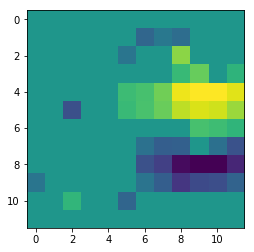

In [72]:
RF_params = load_RF_params_from_datastore(data_store,sheets[0])
RF = RF_params[25080]["Receptive Field"]
RF_masked = RF_params[25080]["Masked Receptive Field"]

%matplotlib inline
plt.imshow(RF_masked)
plt.show()

## Plot layer 4 RFs

In [ ]:
%matplotlib inline
#RFs = l4_RFs
h, w = len(RFs_masked)/5, 5
figure, axis = plt.subplots(h, w)
figure.set_figheight(80)
figure.set_figwidth(15)
for i in range(h):
    for j in range(w):
        n_id = neuron_ids["V1_Exc_L4"][i*w+j]
        axis[i,j].set_title('x: %.2f, y: %.2f\n x_calc: %.2f, y_calc: %.2f\ndiameter: %.2f' % 
                         (l4_params[n_id]["x"],l4_params[n_id]["y"],
                          calculated_neuron_params[n_id]["x"], calculated_neuron_params[n_id]["y"],
                          calculated_neuron_params[n_id]["diameter"]))
        #axis[j].imshow(np.abs(RFs_masked[i*w+j]))
        axis[i,j].imshow(RFs_masked[i*w+j])
        circ = plt.Circle((plot_neuron_params[n_id]["x"], plot_neuron_params[n_id]["y"]),
                           plot_neuron_params[n_id]["diameter"]/2.0,fill=False,color='r')
        axis[i,j].add_artist(circ)
        
plt.show()